In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from scipy.stats import kstest
from statsmodels.stats.multitest import multipletests

In [2]:
# This methods adds the given file's content into a large dataframe
def preprocess(path, algo, reward, vfa, degree, file, data_frame):
    dictionary = {}
    if os.path.isfile(path+algo+"/"+reward+"/"+vfa+"/"+degree+"/"+file+"/hyper_param"):
        file = open(path+algo+"/"+reward+"/"+vfa+"/"+degree+"/"+file+"/hyper_param")
    else:
        return data_frame
            
    for line in file:
        key, value = line.split("=")
        
        dictionary[key] = float(value[:-1])
     

    dictionary["algorithm"] = algo
    dictionary["reward"] = reward
    dictionary["vfa"] = vfa
    dictionary["degree"] = degree
    data_frame = data_frame.append(dictionary, ignore_index=True)
    
    return data_frame

In [3]:
# The method given a dataframe, returns a dataframe consisting of only the columns that show the agents score
# (basically removing )
def get_score_columns(df):
    unwanted = ['algorithm', 'beta', 'degree', 'reward', 'seconds', 'vfa', 'df', 'lr']  # These columns we dont need
    wanted = [column for column in list(df.columns) if column not in unwanted]  # The columns we need but they aint ordered
    output = []  # Here we will stored the sorted columns
    
    step = 1
    if len(wanted) > 32:
        step = 3
    
    num_scores = len(wanted) - 1 
    for num in range(0, num_scores, step):
        name = "%s_score" % (num)
        output.append(name)
    output.append('last_score')
    
    return output

In [5]:
# Here we go over all files to be added in the dataframe

# We specify the path for each task
path_taskone = "./exp1_old/logs/"
path_tasktwo = "./exp2_old/logs/"
path_taskthree = "./exp3/logs/"

# We initialize a Pandas Dataframe for each task
df_one = pd.DataFrame()
df_two = pd.DataFrame()
df_three = pd.DataFrame()

for algo in os.listdir(path_taskone):
    for reward in os.listdir(path_taskone+algo+"/"):
        for vfa in os.listdir(path_taskone+algo+"/"+reward+"/"):
            for degree in os.listdir(path_taskone+algo+"/"+reward+"/"+vfa+"/"):
                for file in os.listdir(path_taskone+algo+"/"+reward+"/"+vfa+"/"+degree+"/"):
                    df_one = preprocess(path_taskone, algo, reward, vfa, degree, file, df_one)
                    
for algo in os.listdir(path_tasktwo):
    for reward in os.listdir(path_tasktwo+algo+"/"):
        for vfa in os.listdir(path_tasktwo+algo+"/"+reward+"/"):
            for degree in os.listdir(path_tasktwo+algo+"/"+reward+"/"+vfa+"/"):
                for file in os.listdir(path_tasktwo+algo+"/"+reward+"/"+vfa+"/"+degree+"/"):
                    df_two = preprocess(path_tasktwo, algo, reward, vfa, degree, file, df_two)
                    
for algo in os.listdir(path_taskthree):
    for reward in os.listdir(path_taskthree+algo+"/"):
        for vfa in os.listdir(path_taskthree+algo+"/"+reward+"/"):
            for degree in os.listdir(path_taskthree+algo+"/"+reward+"/"+vfa+"/"):
                for file in os.listdir(path_taskthree+algo+"/"+reward+"/"+vfa+"/"+degree+"/"):
                    df_three = preprocess(path_taskthree, algo, reward, vfa, degree, file, df_three)

In [71]:
# This method takes the experiment parameters (dataframe, the algorithm, the vfa method, the polynomial degree and the columns to return) 
# and returns some performance statistics (average rewards, 95% confidence over and under) for all runs of each experiments for average
# rewards and discounted returns

def process(df, algo, vfa, degree, cols):
    data_av = df[(df["algorithm"] == algo) & (df["reward"] == 'average') & (df["vfa"] == vfa) & (df["degree"] == degree)].nlargest(10, 'last_score')
    mean_av = data_av[cols].mean()
    std_av = data_av[cols].std()
    ste_av = std_av / np.sqrt(data_av[cols].count())
    nf_over_av = mean_av + 1.96 * ste_av
    nf_under_av = mean_av - 1.96 * ste_av
    
    data_df = df[(df["algorithm"] == algo) & (df["reward"] == 'discounted') & (df["vfa"] == vfa) & (df["degree"] == degree)].nlargest(10, 'last_score')
    mean_df = data_df[cols].mean()
    std_df = data_df[cols].std()
    ste_df = std_df / np.sqrt(data_df[cols].count())
    nf_over_df = mean_df + 1.96 * ste_df
    nf_under_df = mean_df - 1.96 * ste_df
    
    return (mean_av, nf_under_av, nf_over_av, mean_df, nf_under_df, nf_over_df)

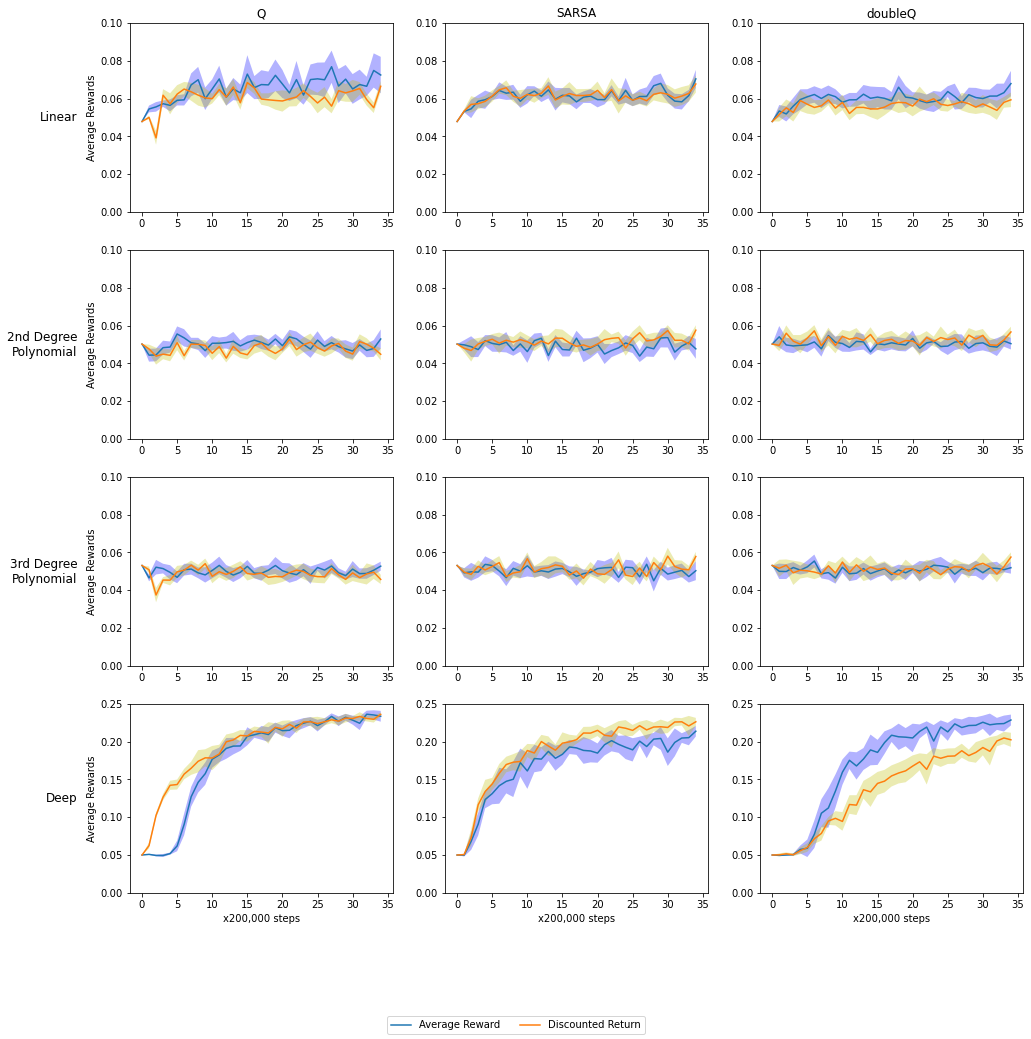

In [94]:
# Here we visualise the training curves for each experiment configuration 

dfr = df_three # here we choose which dataframe to visualise: df_one, df_two, df_three
cols = get_score_columns(dfr)
fig, axs = plt.subplots(4, 3, figsize=(16,16))
x_count = -1

for algorithm in ["Q", "SARSA", "doubleQ"]:
    y_count = 0
    x_count=x_count+1
    axs[y_count, x_count].title.set_text(algorithm)
    for vfa in ["linear", "deep"]:
        if vfa == "linear":
            for degree in ["1", "2", "3"]:
                results = process(dfr, algorithm, vfa, degree, cols)
                axs[y_count, x_count].plot(range(0,len(cols)), results[0], label='Average Reward')
                axs[y_count, x_count].fill_between(range(0,len(cols)), results[1], results[2], alpha=0.3, facecolor='b')
                axs[y_count, x_count].plot(range(0,len(cols)), results[3], label='Discounted Return')
                axs[y_count, x_count].fill_between(range(0,len(cols)), results[4], results[5], alpha=0.3, facecolor='y')
                axs[y_count, x_count].set_ylim(0, 0.1)
                
                if x_count == 0:
                    axs[y_count, x_count].set_ylabel("Average Rewards")
                
                y_count=y_count+1
        else:
            results = process(dfr, algorithm, vfa, "1", cols)
            axs[y_count, x_count].plot(range(0,len(cols)), results[0], label='Average Reward')
            axs[y_count, x_count].fill_between(range(0,len(cols)), results[1], results[2], alpha=0.3, facecolor='b')
            axs[y_count, x_count].plot(range(0,len(cols)), results[3], label='Discounted Return')
            axs[y_count, x_count].fill_between(range(0,len(cols)), results[4], results[5], alpha=0.3, facecolor='y')
            axs[y_count, x_count].set_ylim(0, 0.25)
            
            if x_count == 0:
                    axs[y_count, x_count].set_ylabel("Average Rewards")
                
            axs[y_count,x_count].set_xlabel("x200,000 steps")
            y_count=y_count+1


rows = ["Linear", "2nd Degree\nPolynomial", "3rd Degree\nPolynomial", "Deep"]
for ax, row in zip(axs[:,0], rows):
    ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - 5, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size='large', ha='right', va='center')

handles, labels = axs[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=2)

file_name = "exp3_final_seeded_all.pdf"
plt.savefig(file_name, bbox_inches="tight")

In [15]:
# This method gets the experiment parameters and returns the last_score column of that experiment config
def final_perf(df, algorithm, vfa, degree, reward):
    data = df[(df["algorithm"] == algorithm) & (df["reward"] == reward) & (df["vfa"] == vfa) & (df["degree"] == degree)].nlargest(30, 'last_score')['last_score']
    return data

In [28]:
# Now we will perform the Kolmogorov-Smirnov Statistical Test and input the results in a dictionary

stat_results = {}
task = ""
for algorithm in ["Q", "SARSA", "doubleQ"]:
    for task in ["one", "two", "three"]:
        for vfa in ["linear", "deep"]:
            if vfa == "linear":
                for degree in ["1", "2", "3"]:
                    if task == "one":
                        dataframe = df_one
                    elif task == "two":
                        dataframe = df_two
                    else:
                        dataframe = df_three
                        
                    average_samples = final_perf(dataframe, algorithm, vfa, degree, "average") 
                    discounted_samples = final_perf(dataframe, algorithm, vfa, degree, "discounted") 
                    statistic, p_value = kstest(average_samples, discounted_samples)
                    stat_results[task, algorithm, vfa, degree] = (statistic, p_value)

            else:
                if task == "one":
                    dataframe = df_one
                elif task == "two":
                    dataframe = df_two
                else:
                    dataframe = df_three
                
                average_samples = final_perf(dataframe, algorithm, vfa, "1", "average") 
                discounted_samples = final_perf(dataframe, algorithm, vfa, "1", "discounted")
                statistic, p_value = kstest(average_samples, discounted_samples)
                stat_results[task, algorithm, vfa, "1"] = (statistic, p_value)
            
p_values = [x[1] for x in list(stat_results.values())] # Here we extract the p_values from all the tests

# Here we add whether the null hypothesis is accepted in the stat_results dictionary
i = 0
for key, value in stat_results.items(): 
    if value[1] > 0.05:
        stat_results[key] = stat_results[key] + (False,)
    else:
        stat_results[key] = stat_results[key] + (True,)
    i += 1


[print(key, " : ", value) for key, value in stat_results.items() if key[0]=="one"];
print()
[print(key, " : ", value) for key, value in stat_results.items() if key[0]=="two"];
print()
[print(key, " : ", value) for key, value in stat_results.items() if key[0]=="three"];

('one', 'Q', 'linear', '1')  :  (0.9333333333333333, 2.993288398909619e-14, True)
('one', 'Q', 'linear', '2')  :  (0.9333333333333333, 2.993288398909619e-14, True)
('one', 'Q', 'linear', '3')  :  (0.8666666666666667, 8.246509538996e-12, True)
('one', 'Q', 'deep', '1')  :  (0.43333333333333335, 0.006548396368058784, True)
('one', 'SARSA', 'linear', '1')  :  (0.9666666666666667, 1.0146740335286845e-15, True)
('one', 'SARSA', 'linear', '2')  :  (1.0, 1.6911233892144742e-17, True)
('one', 'SARSA', 'linear', '3')  :  (0.9, 5.78702423789193e-13, True)
('one', 'SARSA', 'deep', '1')  :  (0.5666666666666667, 8.737803591291227e-05, True)
('one', 'doubleQ', 'linear', '1')  :  (0.9333333333333333, 2.993288398909619e-14, True)
('one', 'doubleQ', 'linear', '2')  :  (1.0, 1.6911233892144742e-17, True)
('one', 'doubleQ', 'linear', '3')  :  (0.8666666666666667, 8.246509538996e-12, True)
('one', 'doubleQ', 'deep', '1')  :  (0.8333333333333334, 9.236090683675521e-11, True)

('two', 'Q', 'linear', '1')  :

In [41]:
# Here I will count the number of rejections and acceptances of the null hypothesis and compare them 

count_true_one = 0
count_false_one = 0
count_true_two = 0
count_false_two = 0
for key, value in stat_results.items():
    if key[0] == "one":
        if value[3]:
            count_true_one+=1
        else:
            count_false_one+=1
    else:
        if value[3]:
            count_true_two+=1
        else:
            count_false_two+=1
            
print("The null hypothesis is accepted for task 1 this ammount of times: ", count_true_one)
print("The null hypothesis is rejected for task 1 this ammount of times: ", count_false_one)
print()
print("The null hypothesis is accepted for task 2 this ammount of times: ", count_true_two)
print("The null hypothesis is rejected for task 2 this ammount of times: ", count_false_two)

The null hypothesis is rejected for task 1 this ammount of times:  5
The null hypothesis is accepted for task 1 this ammount of times:  7

The null hypothesis is rejected for task 2 this ammount of times:  6
The null hypothesis is accepted for task 2 this ammount of times:  6
